<a href="https://colab.research.google.com/github/Swathi1309/ED18B034_ME18B133_CS6910/blob/main/Assignment3/Assignment3_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, TimeDistributed
import tarfile
import random
from keras.optimizers import RMSprop, Adam, SGD

In [ ]:
!pip install wandb
!wandb login
import wandb
from wandb.keras import WandbCallback
wandb.init(project="CS6910-assg3", entity="narendv")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Data

In [ ]:
my_tar = tarfile.open('/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0.tar')
my_tar.extractall('/content/drive/MyDrive/Dakshina dataset') # specify which folder to extract to
my_tar.close()

Examples

In [ ]:
import csv
hi_to_eng = open("/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
read_tsv = csv.reader(hi_to_eng, delimiter="\t")
i=0
for row in read_tsv:
  i +=1
  print(row)
  if i==30:
    break
hi_to_eng.close()

In [3]:
# Number of samples to train on.
# Path to the data txt file on disk.
data_path_train = "/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
data_path_dev = '/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'

In [4]:
def load_inputs(data_path,data):
  # Vectorize the data.
  input_texts = []
  target_texts = []
  input_characters = set()
  target_characters = set()
  with open(data_path, "r", encoding="utf-8") as f:
      lines = f.read().split("\n")
  for line in lines[: (len(lines) - 1)]:
      input_text, target_text, _ = line.split("\t")
      # We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
      target_text = "\t" + target_text + "\n"
      input_texts.append(input_text)
      target_texts.append(target_text)
      for char in input_text:
          if char not in input_characters:
              input_characters.add(char)
      for char in target_text:
          if char not in target_characters:
              target_characters.add(char)

  input_characters = sorted(list(input_characters))
  target_characters = sorted(list(target_characters))
  num_encoder_tokens = len(input_characters)
  num_decoder_tokens = len(target_characters)
  global max_encoder_seq_length, max_decoder_seq_length
  if data == 'train':
    max_encoder_seq_length = max([len(txt) for txt in input_texts])
    max_decoder_seq_length = max([len(txt) for txt in target_texts])

  # print("Number of samples:", len(input_texts))
  # print("Number of unique input tokens:", num_encoder_tokens)
  # print("Number of unique output tokens:", num_decoder_tokens)
  # print("Max sequence length for inputs:", max_encoder_seq_length)
  # print("Max sequence length for outputs:", max_decoder_seq_length)

  input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
  target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
  if data == 'train':
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
    )
  if data == 'dev':
    encoder_input_data = np.zeros(
        (len(input_texts), max_encoder_seq_length, input_token_train), dtype="float32"
    )
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, output_token_train), dtype="float32"
    )
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, output_token_train), dtype="float32"
    )
  
  random.seed(0)
  temp = list(zip(input_texts, target_texts))
  random.shuffle(temp)
  it, tt = zip(*temp)
  
  for i, (input_text, target_text) in enumerate(zip(it, tt)):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t, input_token_index[char]] = 1.0
      # encoder_input_data[i, (t + 1):, input_token_index[" "]] = 1.0
      for t, char in enumerate(target_text):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t, target_token_index[char]] = 1.0
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      # decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
      # decoder_target_data[i, t:, target_token_index[" "]] = 1.0

  return encoder_input_data, decoder_input_data, decoder_target_data, num_encoder_tokens, num_decoder_tokens, input_token_index, target_token_index

In [5]:
global enc_input_train, dec_input_train, dec_target_train, input_token_train, output_token_train, input_token_index, target_token_index
global enc_input_dev, dec_input_dev, dec_target_dev
global max_encoder_seq_length, max_decoder_seq_length
enc_input_train, dec_input_train, dec_target_train, input_token_train, output_token_train, input_token_index, target_token_index = load_inputs(data_path_train,'train')
enc_input_dev, dec_input_dev, dec_target_dev, _, _, _, _ = load_inputs(data_path_dev,'dev')

In [6]:
def encoder(enc_out,in_token_no,enc_block, latent_dim, enc_layers):
  for i in range(0,enc_layers):
    if enc_block =='LSTM':
      enc_out ,h ,c = LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      s = [h,c]
    elif enc_block =='GRU':
      enc_out ,s = GRU(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
    else:
      enc_out ,s = SimpleRNN(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
    
  return enc_out,s

In [7]:
def decoder(X_input_dec, hs_init, latent_dim, out_token_no, dec_block, dec_layers, dense_no,drop_no):
  out_dec = X_input_dec
  hs = hs_init
  for i in range (0,dec_layers):
    if dec_block == 'LSTM':
      out_dec, h, s = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs)
      hs = [h,s]
    elif dec_block == 'GRU':
      out_dec, hs = GRU(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs)
    else:
      out_dec, hs = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
  
  # out_dec = Dense(dense_no/2, activation='tanh')(out_dec)
  # out_dec = Dropout(drop_no)(out_dec)
  out_dec = TimeDistributed(Dense(out_token_no, activation="softmax"))(out_dec)

  return out_dec

In [8]:
def RNN_model(in_token_no, enc_block, latent_dim, out_token_no, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(None, in_token_no))
  X_input_dec = keras.Input(shape=(None, out_token_no))
  _,s_init = encoder(X_input_enc,in_token_no,enc_block, latent_dim, enc_layers)
  out_dec = decoder(X_input_dec,s_init,latent_dim, out_token_no, dec_block, dec_layers, dense_no, drop_no)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')
  return model

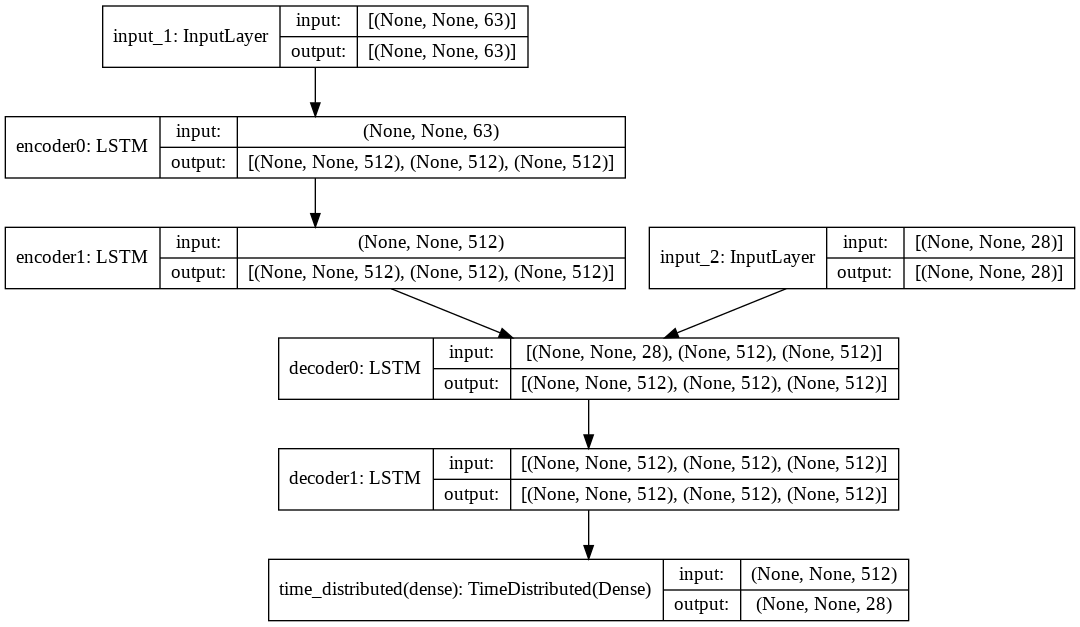

In [9]:
  model = RNN_model(input_token_train,'LSTM',512,output_token_train,'LSTM', 256, 0, 2, 2)
  keras.utils.plot_model(model,show_shapes=True, rankdir='TB')

In [ ]:
def enc_inference(model,enc_layers):
  X_in_enc = model.input[0]
  enc_outputs = X_in_enc
  for i in range(0,enc_layers):
    enc_outputs, h_enc, s_enc = model.get_layer('encoder'+str(i))(enc_outputs)
  X_out_enc = [h_enc, s_enc]
  enc_model = keras.Model(inputs = X_in_enc, outputs = X_out_enc)

  return enc_model

def dec_inference(model, latent_dim, dec_layers):
  dec_inputs = model.input[1]
  print(tf.shape(dec_inputs))
  dec_outputs = dec_inputs
  dec_input_h = keras.Input(shape=(latent_dim,))
  dec_input_s = keras.Input(shape=(latent_dim,))
  hs_inputs = [dec_input_h,dec_input_s]
  hs_outputs = hs_inputs
  for i in range(0,dec_layers):
    dec_outputs, h_dec, s_dec = model.get_layer('decoder'+str(i))(dec_outputs, initial_state=hs_outputs)
    hs_outputs = [h_dec, s_dec]
    print(tf.shape(dec_outputs))
    print(tf.shape(hs_outputs))
  dec_dense = model.layers[-1]
  dec_outputs = dec_dense(dec_outputs)
  dec_model = keras.Model(inputs = [dec_inputs] + hs_inputs, outputs = [dec_outputs] + hs_outputs)
  
  return dec_model

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

def decode_sequence(input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, output_token_train))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, output_token_train))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
model.compile(optimizer=RMSprop(1e-2), loss = 'categorical_crossentropy', metrics='accuracy')
model.fit([enc_input_train,dec_input_train], dec_target_train,
            batch_size = 128,epochs=20, validation_data=([enc_input_dev,dec_input_dev], dec_target_dev))

Epoch 1/20
346/346 [==============================] - 20s 45ms/step - loss: 1.1496 - accuracy: 0.0655 - val_loss: 0.9713 - val_accuracy: 0.0900
Epoch 2/20
346/346 [==============================] - 15s 42ms/step - loss: 0.8498 - accuracy: 0.1217 - val_loss: 0.8464 - val_accuracy: 0.1773
Epoch 3/20
346/346 [==============================] - 15s 42ms/step - loss: 0.2847 - accuracy: 0.2878 - val_loss: 0.4716 - val_accuracy: 0.2900
Epoch 4/20
346/346 [==============================] - 15s 42ms/step - loss: 0.0586 - accuracy: 0.3548 - val_loss: 0.3618 - val_accuracy: 0.3162
Epoch 5/20
346/346 [==============================] - 15s 42ms/step - loss: 0.0238 - accuracy: 0.3661 - val_loss: 0.3445 - val_accuracy: 0.3213
Epoch 6/20
346/346 [==============================] - 15s 42ms/step - loss: 0.0140 - accuracy: 0.3694 - val_loss: 0.3300 - val_accuracy: 0.3243
Epoch 7/20
346/346 [==============================] - 15s 42ms/step - loss: 0.0094 - accuracy: 0.3702 - val_loss: 0.3449 - val_accuracy:

In [ ]:
enc_input_dev[10].shape

(19, 63)

In [ ]:
def train(model,latent_dim,enc_layers, dec_layers):
  enc_block = enc_inference(model, enc_layers)
  dec_block = dec_inference(model,latent_dim, dec_layers)
  keras.utils.plot_model(dec_block,show_shapes=True)
  input_seq = tf.expand_dims(enc_input_dev[10],0)
  decoded_word = decode_sequence(input_seq, enc_block, dec_block)

  return decoded_word

In [ ]:
enc_block = enc_inference(model, 2)
dec_block = dec_inference(model,512, 2)

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, None, 28], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, None, 512], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[2, None, 512], name='tf.compat.v1.shape_2/Shape:0', description="created by layer 'tf.compat.v1.shape_2'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, None, 512], name='tf.compat.v1.shape_3/Shape:0', description="created by layer 'tf.compat.v1.shape_3'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[2, None, 512], name='tf.compat.v1.shape_4/Shape:0', description="created by layer 'tf.compat.v1.shape_4'")


In [ ]:
print(train(model,512,2,2))

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, None, 28], name='tf.compat.v1.shape_20/Shape:0', description="created by layer 'tf.compat.v1.shape_20'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, None, 512], name='tf.compat.v1.shape_21/Shape:0', description="created by layer 'tf.compat.v1.shape_21'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[2, None, 512], name='tf.compat.v1.shape_22/Shape:0', description="created by layer 'tf.compat.v1.shape_22'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, None, 512], name='tf.compat.v1.shape_23/Shape:0', description="created by layer 'tf.compat.v1.shape_23'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[2, None, 512], name='tf.compat.v1.shape_24/Shape:0', description="created by layer 'tf.compat.v1.shape_24'")
la

In [ ]:
# model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics='accuracy')
model.fit([enc_input_train,dec_input_train], dec_target_train,
          batch_size = 64,epochs=40, validation_data=([enc_input_dev,dec_input_dev], dec_target_dev))

In [ ]:
import pprint

In [ ]:
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    'encoder_block':{
        'values': ['LSTM']
      },
    # 'encoder_layers': {
    #     'values': [1,2,3]
    #   },
    'decoder_block':{
      'values' : ['LSTM']
      },
    # 'decoder_layers': {
    #     'values': [1,2,3]
    #   },
    'latent_dimension': {
        'values': [256]
      },
    'hidden_layer': {
        'values': [128]
      },
    'dropout': {
        'values': [0]
      },
    'epochs' : {
        'values' : [60]
    }
}

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

def training_sweep(config=None):
    with wandb.init(config=config):
        print(input_token_train)
        config = wandb.config
        print(output_token_train)
        model = RNN_model(input_token_train, config.encoder_block, config.latent_dimension, output_token_train, config.decoder_block,  config.hidden_layer, config.dropout)
        print('lol')
        model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics='accuracy')
        print('lol')
        history = model.fit([enc_input_train,dec_input_train], dec_target_train, 
                            epochs=config.epochs,
                            validation_data = ([enc_input_dev,dec_input_dev], dec_target_dev),
                            callbacks = [WandbCallback()]
                            )
        print('lol')
        name = str(config.encoder_block) + '_' + str(config.encoder_layers) + '_' + str(config.decoder_block) + '_' + str(config.decoder_layers) + '_' + str(config.hidden_layer) + '_' + str(config.dropout) + '_' + str(config.epochs)
        location = '/content/drive/MyDrive/Transliteration/' + name
        model.save(location)

{'method': 'grid',
 'parameters': {'decoder_block': {'values': ['LSTM']},
                'dropout': {'values': [0]},
                'encoder_block': {'values': ['LSTM']},
                'epochs': {'values': [60]},
                'hidden_layer': {'values': [128]},
                'latent_dimension': {'values': [256]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="CS6910-assg3")
wandb.agent(sweep_id, training_sweep)